# Prepoznavanje oblika

Autor: Djordje Marjanovic 2016/0120

## Zadatak 1

Za bazu rukom pisanih samoglasnika, koja je dostupna na sajtu predmeta*
isprojektovati inovativni sistem za prepoznavanje cifara zasnovan na
testiranju hipoteza. Rezultate prikazati u obliku matrice konfuzije. Izveštaj
treba da sadrži kratki opis isprojektovanog sistema, obrazložen izbor
obeležja, kao i karakteristične primere pravilno i nepravilno klasifikovanih
slova.

### Postavka

In [4]:
%reset -f

import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

dataset_dir = "data/Slova/"
letters = ['A', 'E', 'I', 'O', 'U']
train_set_size_per_letter = 80
val_set_size_per_letter = 20
test_set_size_per_letter = 20

### Učitavanje podataka

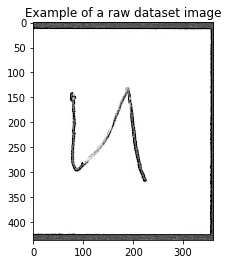

In [5]:
train_set = []
for letter in letters:
    for idx in list(range(1, train_set_size_per_letter + 1)):
        img = cv2.imread("{}baza{}{:03d}.bmp".format(dataset_dir, letter, idx))
        train_set.append((letter, img))
        
val_set = []
for letter in letters:
    indices = range(
        train_set_size_per_letter + 1,
        val_set_size_per_letter + train_set_size_per_letter + 1
    )
    for idx in list(indices):
        img = cv2.imread("{}baza{}{:03d}.bmp".format(dataset_dir, letter, idx))
        val_set.append((letter, img))
       
test_set = []
for letter in letters:
    indices = range(
        train_set_size_per_letter + 1,
        val_set_size_per_letter + train_set_size_per_letter + 1
    )
    for idx in list(indices):
        img = cv2.imread("{}baza{}{:03d}.bmp".format(dataset_dir, letter, idx))
        test_set.append((letter, img))

random_point_index = random.randint(0, len(train_set))

random_point = train_set[random_point_index]
plt.imshow(random_point[1])
plt.title("Example of a raw dataset image")
plt.show()

### Priprema slika

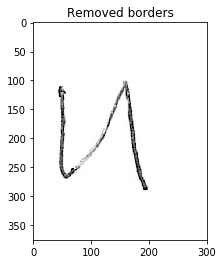

In [6]:
border_size = 30
train_set = [(
    label,
    sample[
        border_size : sample.shape[0] - border_size,
        border_size : sample.shape[1] - border_size
    ][:, :, 0] / 256.0
) for label, sample in train_set]

val_set = [(
    label,
    sample[
        border_size : sample.shape[0] - border_size,
        border_size : sample.shape[1] - border_size
    ][:, :, 0] / 256.0
) for label, sample in val_set]

test_set = [(
    label,
    sample[
        border_size : sample.shape[0] - border_size,
        border_size : sample.shape[1] - border_size
    ][:, :, 0] / 256.0
) for label, sample in test_set]

random_point = train_set[random_point_index]
plt.imshow(random_point[1], cmap = 'gray')
plt.title("Removed borders")
plt.show()

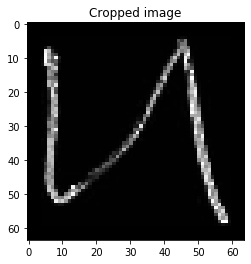

In [7]:
def crop(image: np.ndarray):
    from scipy.ndimage.morphology import binary_erosion, binary_dilation
    binary_threshold = 0.9
    erosion_size = 2
    padding = 4
    final_size = (64, 64)
    
    binary_image = 1.0 * image < binary_threshold
    binary_image = binary_erosion(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    binary_image = binary_dilation(
        binary_image, 
        structure = np.ones((erosion_size, erosion_size))
    )
    
    x, y = np.meshgrid(range(image.shape[1]), range(image.shape[0]))
    x = x * binary_image
    y = y * binary_image
    
    u_bound = max(0, np.min(y[np.nonzero(y)]) - erosion_size)
    b_bound = min(image.shape[0] - 1, y.max() + erosion_size + 1)
    l_bound = max(0, np.min(x[np.nonzero(x)]) - erosion_size)
    r_bound = min(image.shape[1] - 1, x.max() + erosion_size + 1)
    
    cropped_image = image[u_bound: b_bound, l_bound: r_bound]
    resized_image = cv2.resize(
        src = cropped_image,
        dsize = (final_size[1] - 2 * padding, final_size[0] - 2 * padding)
    )
    
    final_image = np.ones(final_size)
    final_image[
        padding: final_size[0] - padding,
        padding: final_size[1] - padding
    ] = resized_image
    
    return 1 - final_image

train_set = [(label, crop(sample)) for label, sample in train_set]
val_set = [(label, crop(sample)) for label, sample in val_set]
test_set = [(label, crop(sample)) for label, sample in test_set]

random_point = train_set[random_point_index]
plt.imshow(random_point[1], cmap = 'gray')
plt.title("Cropped image")
plt.show()

### Funkcije za vizuelizaciju

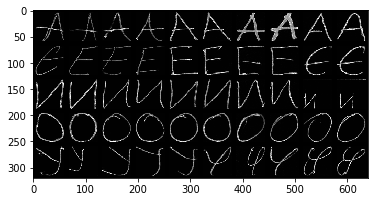

In [8]:
def display_square(imgs: list, n: int, m: int):
    w, h = imgs[0].shape
    comb = np.zeros((h * n, w * m))
    for i in range(n):
        for j in range(m):
            comb[i * h: (i + 1) * h, j * w: (j + 1) * w] =\
                imgs[i * m + j]
    plt.imshow(comb, cmap = 'gray')
    plt.show()

# images per label
ipl = len(train_set) // len(letters)
display_set = sum([
    train_set[i * ipl: i * ipl + 10] 
    for i in range(len(letters))
], [])
display_square([img for label, img in display_set], 5, 10)

### Vestacko povecanje baze

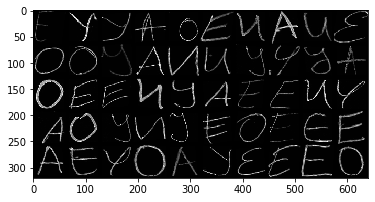

In [9]:
def generate_augmented_image(image: np.ndarray, variance: float = 0.3):
    translate_to_center = np.eye(3)
    translate_to_center[:2, 2] = -np.array(image.shape).T / 2

    translate_from_center = np.eye(3)
    translate_from_center[:2, 2] = np.array(image.shape).T / 2

    affine = np.zeros((3, 3))
    affine[:2, :2] = np.eye(2) + (np.random.rand(2, 2) - 0.5) * variance
    affine[2, :] = np.array([0, 0, 1])
    affine[:2, 2] = (np.random.rand(2) - 0.5) * variance

    final = translate_from_center.dot(affine.dot(translate_to_center)) 
    
    return cv2.warpPerspective(image, final, image.shape, borderValue=0)

augmentation_ratio = 2
augmented_train_set = []
for label, image in train_set:
    augmented_train_set.append((label, image))
    for i in range(augmentation_ratio):
        augmented_train_set.append((label, generate_augmented_image(image)))

random.shuffle(augmented_train_set)
display_square([img for label, img in augmented_train_set[:50]], 5, 10)

### Karakteristike

In [10]:
import features

selected_features = [
    features.Stack([
        features.RectSelect(20, 43, 20, 43),
        features.Mean()
    ]),
    features.Stack([
        features.RectSelect(0, 63, 0, 20),
        features.Mean()
    ]),
    features.Stack([
        features.RectSelect(0, 63, 43, 63),
        features.Mean()
    ]),
    features.Stack([
        features.RectSelect(0, 31, 0, 63),
        features.Mean()
    ]),
    features.Stack([
        features.RectSelect(32, 63, 0, 63),
        features.Mean()
    ])
]

X = np.array([
    [letters.index(letter)] + [
        feature.get_feature(sample)
        for feature in selected_features
    ]
    for letter, sample in train_set
])

X_test = np.array([
    [letters.index(letter)] + [
        feature.get_feature(sample)
        for feature in selected_features
    ]
    for letter, sample in val_set
])

print(selected_features[0].get_feature(random_point[1]))

0.05003066048383575


### Vizuelizacija karakteristika

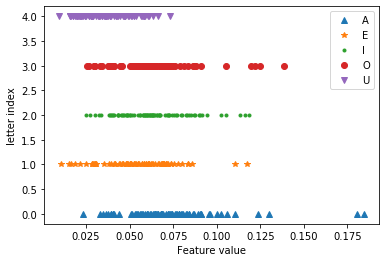

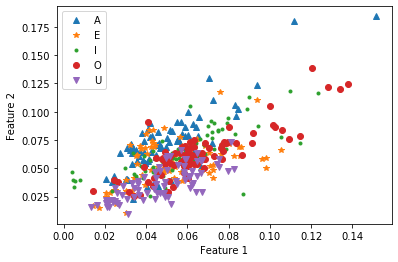

In [11]:
letter_to_symbol = {
    'A': '^',
    'E': '*',
    'I': '.',
    'O': 'o',
    'U': 'v',
}


def feature_distribution(feature_id: int):
    for letter_id in range(len(letters)):
        plt.plot(
            X[X[:, 0] == letter_id][:, feature_id + 1],
            np.ones(train_set_size_per_letter) * letter_id,
            letter_to_symbol[letters[letter_id]]
        )
    plt.legend(letters)
    plt.xlabel('Feature value')
    plt.ylabel('letter index')
    plt.show()


def compare_features(feature1_id: int = 0, feature2_id: int = 1):
    for letter_id in range(len(letters)):
        feature_for_letter_id = X[X[:, 0] == letter_id] 
        plt.plot(
            feature_for_letter_id[:, feature1_id + 1],
            feature_for_letter_id[:, feature2_id + 1],
            letter_to_symbol[letters[letter_id]]
        )
    plt.legend(letters)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

feature_distribution(4)
compare_features(3, 4)
    

### Estimator distribucija

In [12]:
M = np.array([
    np.mean(X[X[:, 0] == letter_id], axis=0)
    for letter_id in range(len(letters))
])[:, 1:]

S = np.array([
    np.cov(X[X[:, 0] == letter_id][:, 1:].T)
    for letter_id in range(len(letters))
])

### Testiranje hipoteza

In [13]:
q = [
    scipy.stats.multivariate_normal(mean=M[letter_id], cov=S[letter_id]).pdf(
        X_test[:, 1:]
    )
    for letter_id in range(len(letters))
]

q = np.array(q)

pred = np.argmax(q, axis=0)
confusion_matrix = np.zeros((len(letters), len(letters)))
for i in range(X_test.shape[0]):
    confusion_matrix[int(X_test[i, 0]), pred[i]] += 1
    
print(end='\t')
for letter in letters:
    print(letter, end='\t')
print()    
for i, letter in enumerate(letters):
    print(letter, end='\t')
    for j in range(len(letters)):
        print(confusion_matrix[i][j], end='\t')
    print()
print()
print("accuracy =",
      np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix)
)

	A	E	I	O	U	
A	18.0	0.0	0.0	1.0	1.0	
E	2.0	18.0	0.0	0.0	0.0	
I	1.0	2.0	16.0	0.0	1.0	
O	0.0	0.0	0.0	19.0	1.0	
U	2.0	0.0	2.0	0.0	16.0	

accuracy = 0.87


### Optimizacija karakteristika

Execution time:

not parallel: 28.5

1 process:   27.4

2 processes: 15.3

4 processes: 9.4

**8 processes: 7.9**

16 processes: 7.1

In [61]:
def model_from_vector(vector: np.ndarray):
    return [
        features.Stack([
            features.RectSelect(
                vector[4 * i],
                vector[4 * i + 1],
                vector[4 * i + 2],
                vector[4 * i + 3]
            ), 
            features.Mean()
        ])
        for i in range(len(vector) // 4)
    ]


def evaluate_model(model, evaluation_set = val_set): 
    
    if sum(model[1::2] - model[::2] < 10) != 0:
        return -1
    
    selected_features = model_from_vector(model)
    
    X = np.array([
        [letters.index(letter)] + [
            feature.get_feature(sample)
            for feature in selected_features
        ]
        for letter, sample in augmented_train_set
    ])

    X_test = np.array([
        [letters.index(letter)] + [
            feature.get_feature(sample)
            for feature in selected_features
        ]
        for letter, sample in evaluation_set
    ])
    
    M = np.array([
        np.mean(X[X[:, 0] == letter_id], axis=0)
        for letter_id in range(len(letters))
    ])[:, 1:]
    
    S = np.array([
        np.cov(X[X[:, 0] == letter_id][:, 1:].T)
        for letter_id in range(len(letters))
    ])
    
    try:
        q = np.array([
            scipy.stats.multivariate_normal(mean=M[letter_id], cov=S[letter_id]).pdf(
                X_test[:, 1:]
            )
            for letter_id in range(len(letters))
        ])
    except:
        return -1
    
    return np.sum(np.argmax(q, axis=0) == X_test[:, 0]) / X_test.shape[0]


def process_model(args):
    model, queue, lock = args
    
    fitness = evaluate_model(model)
    
    lock.acquire()
    queue.append((fitness, model))
    lock.release()
    
    
def select_best_models(
        models: np.ndarray,
        selection_rate: float = 0.5,
        thread_count: int = 8):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    if thread_count > 1:
        import multiprocessing as mp
    
        queue_lock = mp.Manager().Lock()
        model_queue = mp.Manager().list()
        
        pool = mp.Pool(processes = 8)
        pool.map(process_model, [
            (model, model_queue, queue_lock) for model in models
        ])
    
        pool.close()
        pool.join()
    
        return np.array([
            model for fitness, model in sorted(
                model_queue,
                key = lambda pair: -pair[0]
            )[:int(selection_rate * models.shape[0])]
        ])
    else:
        return np.array([
                model for fitness, model in sorted([
                    (evaluate_model(model), model)
                    for model in models
                ],
                key = lambda pair: -pair[0])[:int(selection_rate * models.shape[0])]
            ])


def crossover(models, final_count = 100):
    parent_indices = np.random.randint(
        models.shape[0],
        size = final_count - models.shape[0]
    )
    
    parents = models[parent_indices]
    shuffled_parents = parents.copy()
    np.random.shuffle(shuffled_parents)
    selection = np.random.rand(*parents.shape) < 0.5
    
    parents = np.concatenate([
        parents,
        shuffled_parents
    ], axis=0)
    selection = np.concatenate([
        selection,
        1 - selection
    ], axis=0)
    
    children = parents * selection
    child_count = parents.shape[0] // 2
    
    return np.concatenate([
            models,
            children[: child_count, :] + children[child_count:,:]
        ], axis=0) 
    

def mutate(
        models,
        randomization_rate : float = 0.01,
        shift_rate : float = 0.05):
    randomization_select = np.random.rand(*models.shape) < randomization_rate
    shift_select = np.random.rand(*models.shape) < shift_rate
    
    return (models * (1 - randomization_select) +
        randomization_select * np.random.rand(*models.shape) * 64 +
        shift_select * (np.random.randn(*models.shape) * 3)).astype(int)


def initialize(param_count: int = 20, population_count: int = 100):
    v1 = (np.random.rand(population_count, param_count // 2) * 32)
    v2 = (np.random.rand(population_count, param_count // 2) * 32)
    v_combined = np.zeros((v1.shape[0], v1.shape[1] + v2.shape[1]))
    v_combined[:, ::2] = v1
    v_combined[:, 1::2] = v2 + 32
    return v_combined.astype(int)

In [62]:
models = initialize(population_count = 100)
models = select_best_models(models, selection_rate = 0.2)

In [64]:
import time
start_time = time.time()

for k in range(5):
    print("Iteration {}:".format(k))
    models = crossover(models, final_count=100)
    models = mutate(models, shift_rate = 0.1 / (k + 1))
    models = select_best_models(models, selection_rate = 0.2)
    
    print("Accuracy: {}".format(evaluate_model(models[0], test_set)))

print("Execution time: {}".format(time.time() - start_time))

Iteration 0:
Accuracy: 0.9
Iteration 1:
Accuracy: 0.88
Iteration 2:
Accuracy: 0.92
Iteration 3:
Accuracy: 0.92
Iteration 4:
Accuracy: 0.92
Execution time: 7.623824119567871


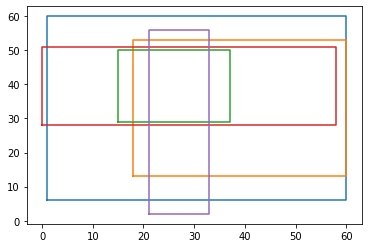

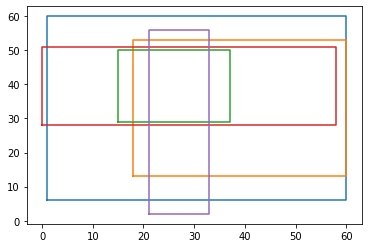

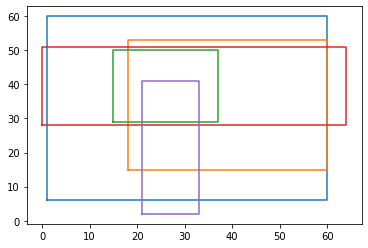

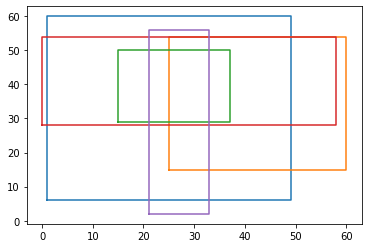

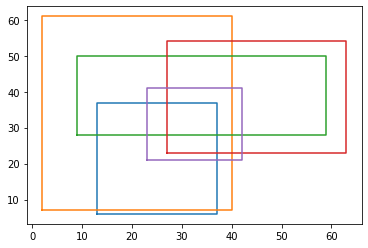

In [65]:
for model_id in range(5):
    for i in range(models.shape[1] // 4):
        top = models[model_id, 4 * i]
        bottom = models[model_id, 4 * i + 1]
        left = models[model_id, 4 * i + 2]
        right = models[model_id, 4 * i + 3]
        
        plt.plot(
            [left, right, right, left, left],
            [top, top, bottom, bottom, top]
        )
    plt.show()